In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
from tqdm.notebook import tqdm
from typing import List, Tuple, Union

import candle.functions as F
import candle.optimizer

### (1) Define ResNet

In [3]:
def get_gpt(n_layers: int):
    model = candle.models.gpt.GPT(n_layers,
                                  n_heads=4,
                                  embed_dim=32,
                                  vocab_size=100,
                                  block_size=2048,
                                  dropout_p=0)

    return model

### (2) Gradient / Activation Norm By Layer

In [4]:
def activation_and_gradient_norm_by_layer(n_layers: int, n_trials: int = 10):

    activation_norm_df = pd.DataFrame()
    grad_norm_df = pd.DataFrame()
    
    for trial in range(n_trials):
        embed_dim = 128
        
        model = get_gpt(n_layers)
        model.init_weights()
        
        layer_activations = {}
        def store_activations(layer_name):
            def hook_fn(module, input, output):
                layer_activations[layer_name] = np.linalg.norm(output.data)
            
            return hook_fn
            
        for (i, layer) in enumerate(model.decoder_blocks):
            layer.register_forward_hook(store_activations(i))    
        
        x = candle.Tensor(np.random.choice(range(50), 20)).astype(np.int32).unsqueeze(0)
        y = candle.Tensor(np.random.choice(range(50), 20)).astype(np.int32).unsqueeze(0)
        
        output = model(x)
        
        loss = F.cross_entropy_loss(output, y)
        
        loss.backward()
        
        activation_norms = list(layer_activations.values())
        grad_norms = [np.linalg.norm(layer.ffn.linear1.W.grad) for layer in model.decoder_blocks]
        
        activation_norm_df[trial] = activation_norms
        grad_norm_df[trial] = grad_norms
    
    fig = plt.figure(figsize=(16, 12))
    
    ax = fig.add_subplot(2, 2, 1)
    
    activation_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Activation Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 2)
    
    grad_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Gradient Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 3)
    
    np.square(activation_norm_df.mean(axis=1)).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Squared Activation Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 4)
    
    (1 / np.square(grad_norm_df.mean(axis=1))).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('1 / Squared Gradient Norm by Layer')
    ax.grid(linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

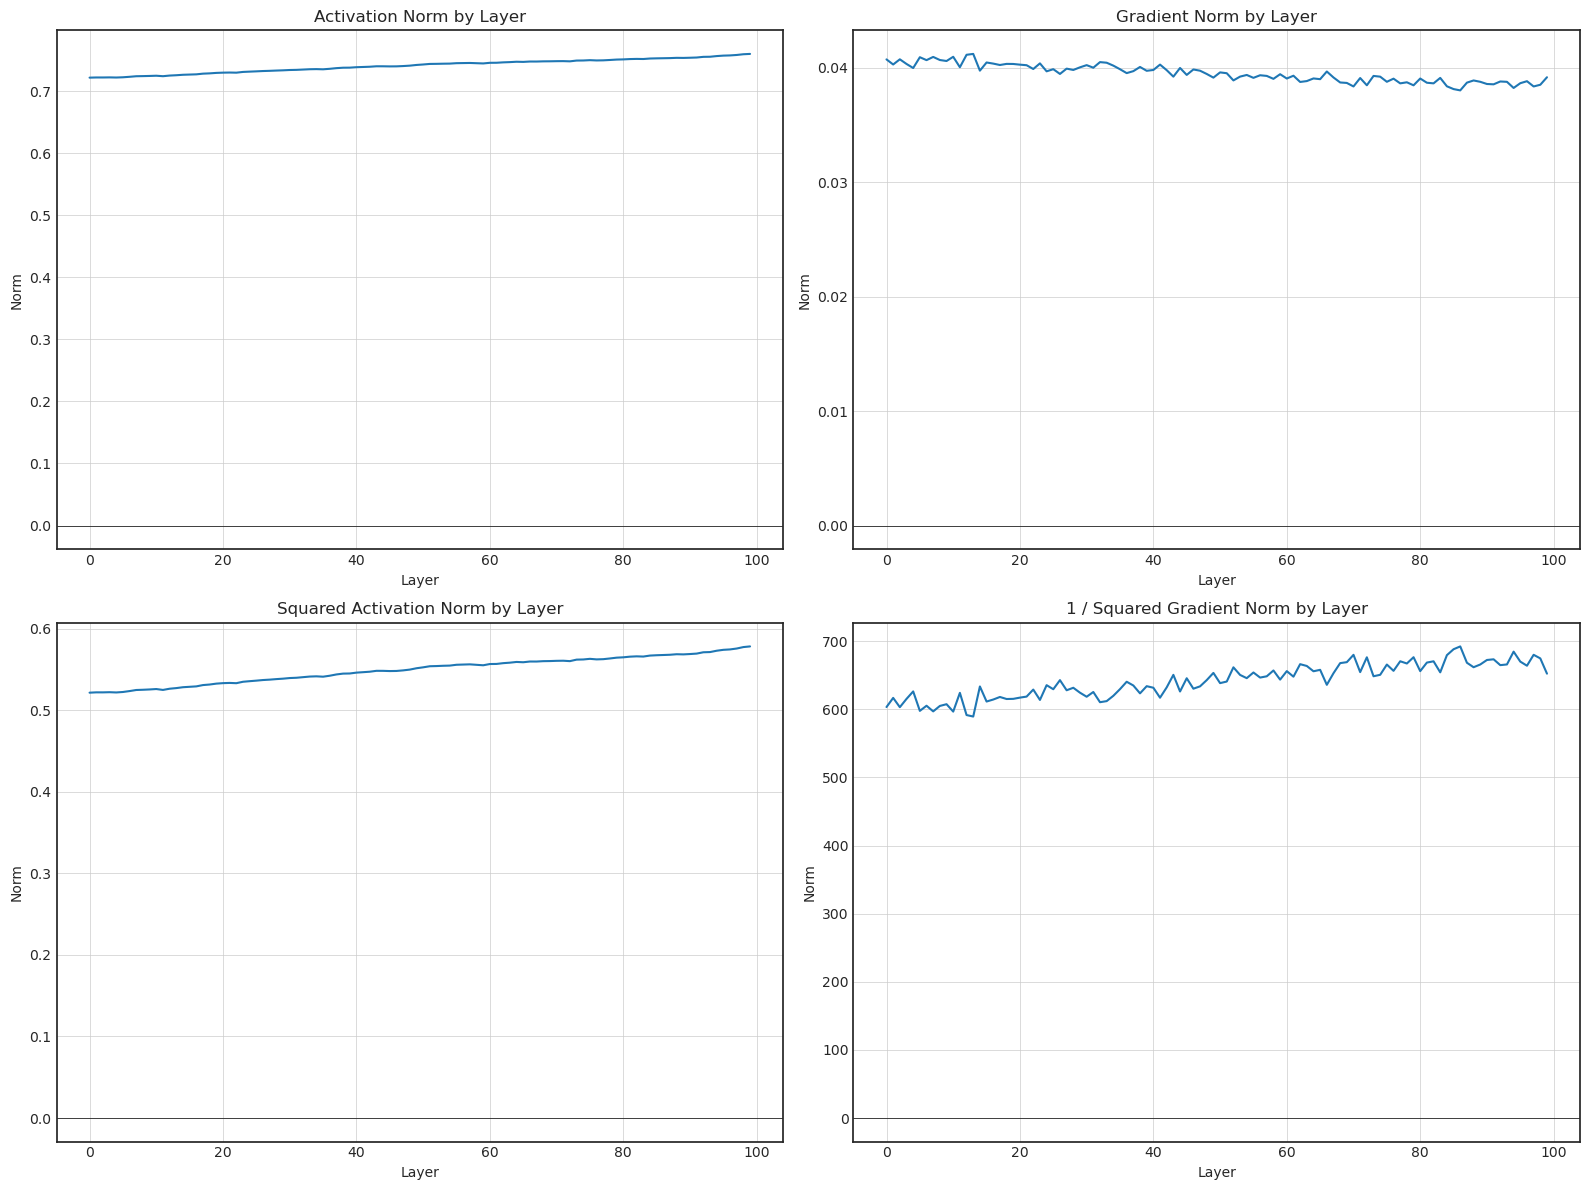

In [6]:
activation_and_gradient_norm_by_layer(n_layers=100)

#### (2.1) Investigate Activations

In [35]:
self = get_gpt(n_layers=20)
self.init_weights()

indices = candle.Tensor(np.random.choice(range(50), 20)).astype(np.int32).unsqueeze(0)

position_indices = candle.Tensor(np.arange(indices.shape[1]))

x = self.word_embeddings(indices) + self.position_embeddings(position_indices)
x = self.dropout(x)  # shape (batch, seqlen, embed_dim)
print('norm(x) post-embed: ', np.linalg.norm(x.data))

for (i, decoder_block) in enumerate(self.decoder_blocks):
    x = decoder_block(x, use_kv_cache=False)
    print(f'norm(x) post-layer{i}:', np.linalg.norm(x.data))

x = self.layer_norm(x)

norm(x) post-embed:  0.6951361
norm(x) post-layer0: 0.69687724
norm(x) post-layer1: 0.699727
norm(x) post-layer2: 0.69867384
norm(x) post-layer3: 0.7023792
norm(x) post-layer4: 0.7067327
norm(x) post-layer5: 0.70492375
norm(x) post-layer6: 0.7046456
norm(x) post-layer7: 0.70624703
norm(x) post-layer8: 0.70566905
norm(x) post-layer9: 0.7080342
norm(x) post-layer10: 0.71235865
norm(x) post-layer11: 0.7174372
norm(x) post-layer12: 0.719634
norm(x) post-layer13: 0.7178616
norm(x) post-layer14: 0.7202992
norm(x) post-layer15: 0.7224474
norm(x) post-layer16: 0.72723424
norm(x) post-layer17: 0.7258504
norm(x) post-layer18: 0.7260486
norm(x) post-layer19: 0.73041147


> At init, each block is roughly the identity function.

### (3) Total Gradient Norm vs Num Layers

In [36]:
def total_activation_and_gradient_norm(n_layers_list: List[int], n_trials: int = 10):

    grad_norm_df = pd.DataFrame()
    
    for trial in range(n_trials):
        for n_layers in n_layers_list:
            embed_dim = 128
            
            model = get_gpt(n_layers)
            model.init_weights()
            
            x = candle.Tensor(np.random.choice(range(50), 20)).astype(np.int32).unsqueeze(0)
            y = candle.Tensor(np.random.choice(range(50), 20)).astype(np.int32).unsqueeze(0)
            
            output = model(x)
            
            loss = F.cross_entropy_loss(output, y)
            
            loss.backward()
            
            grad_norm = np.sqrt(np.sum([np.linalg.norm(layer.ffn.linear1.W.grad) ** 2 for layer in model.decoder_blocks]))
            
            grad_norm_df.loc[n_layers, trial] = grad_norm
    
    fig = plt.figure(figsize=(16, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    
    grad_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('# Layers')
    ax.set_ylabel('Norm')
    ax.set_title('Total Gradient Norm')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(1, 2, 2)
    
    np.square(grad_norm_df.mean(axis=1)).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('# Layers')
    ax.set_ylabel('Norm')
    ax.set_title('Squared Total Gradient Norm')
    ax.grid(linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

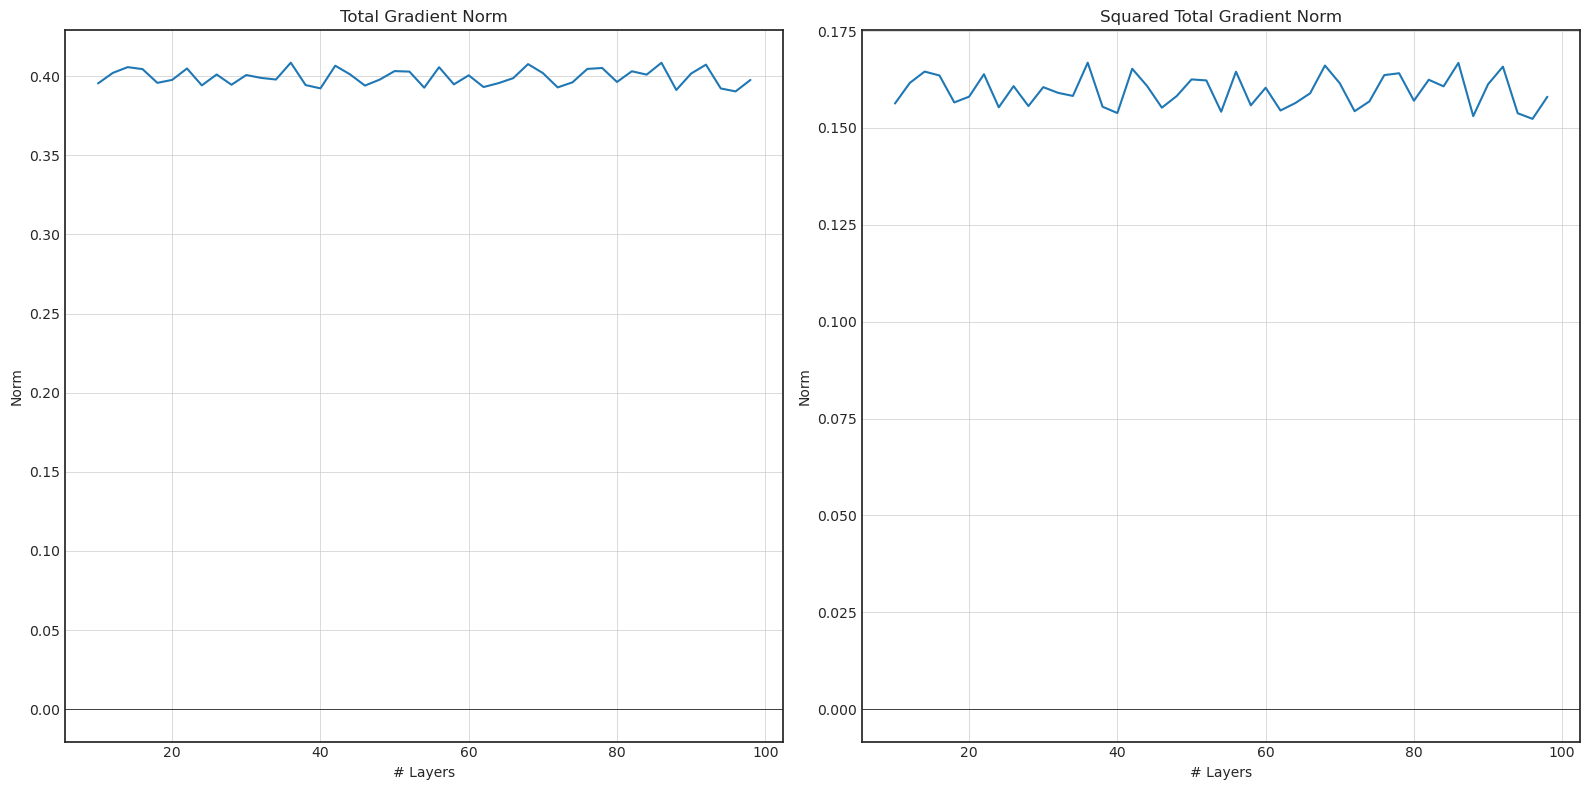

In [37]:
total_activation_and_gradient_norm(n_layers_list=list(range(10, 100, 2)), n_trials=20)